# **COFFEE LEAF DISEASE IMAGE CLASSIFICATION**
Collaborators:
- Crystal Wanjiru
- Randell Mwania
- Victorine Imbuhila
- Sadi Kiri
- Ian Kedeyie
- Simon Ng'ethe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Overview**
## **Business Understanding**
The project aims to address the significant threat posed by three major diseases—Coffee rust, Cercospora, and Phoma—to coffee plants in the highland areas of Kenya. These diseases have the potential to adversely impact the livelihoods of small-scale farmers who heavily depend on coffee cultivation. By implementing a technological solution for early and accurate detection of these diseases, the project seeks to empower farmers to take timely preventive measures, such as the application of fungicides, to mitigate the impact on their crops. The ultimate goal is to preserve the cultural and economic significance of coffee cultivation and contribute to the sustainability of Arabica coffee farming in the region.

## **Problem Statement**
The highland areas of Kenya, characterised by a rich tradition of coffee cultivation, face a critical challenge with the prevalence of three major diseases—coffee rust, cercospora, and phoma. These diseases severely threaten the coffee plants, endangering the livelihoods of small-scale farmers who rely heavily on coffee cultivation. The lack of early and accurate detection methods hampers farmers' ability to implement timely preventive measures, leading to significant crop losses. The absence of a technological solution increases the vulnerability of the coffee industry in the region, putting at risk not only the economic well-being of farmers but also the cultural heritage associated with coffee production.

## **Objectives**
#####**Main Objective:**
To develop a Convolutional Neural Network(CNN) based image classifcation model capable of accurarely distingushing between the three classes of Coffee leaf diseases.

Specific Objectives:
- To identify any patterns or anomalies in the data that may influence model performance.
- To train the model using the provided dataset and evaluate its perfomance on a separate validation set.
- To deploy the trained model making it accessible for stakeholders.

# **Data Understanding**
The dataset contains leaf images which were collected from Arabica coffee type and it shows three sets of Phoma, Rust and Cescospora images and one set of healthy images. The data was obtained from [Dataset on Mendeley](https://data.mendeley.com/datasets/t2r6rszp5c/1), [Dataset on Mendeley](https://data.mendeley.com/datasets/tgv3zb82nd/1) and web scrapping with the 'Download All images' extension from the chrome web store.



In [2]:
# Import relevant libraries
import imghdr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model


In [3]:
# Specify the path to the main folder containing subfolders for each class
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'

# Get a list of subfolders (each subfolder corresponds to a class)
class_folders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))and folder != ".ipynb_checkpoints"]

# Display the number of classes
num_classes = len(class_folders)
print(f"Number of Classes: {num_classes}")

# Display the number of images in each class
for class_name in class_folders:
    class_path = os.path.join(main_folder_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of Images: {num_images}")


Number of Classes: 4
Class: Phoma, Number of Images: 6571
Class: Healthy, Number of Images: 8587
Class: Cerscospora, Number of Images: 6200
Class: Leafrust, Number of Images: 8315


The data contains 29,673 images from four different classes. One set contains 8587 images of healthy coffee leaves while the other 3 contain 6571 images of Phoma, 6200 images of Cercospora and 8315 images of Leafrust.

# **Data Preparation**
The data pre-processing involved noise filtering and contrast stretching. To ensure uniformity, non-square images were cropped to obtain central square portions. To mitigate overfitting and enhance smaller datasets, data augmentation techniques such as rotation and flipping were applied, expanding the collected field images into larger datasets.

In [4]:
# Getting rid of any images that are not jpeg, jpg, bmp or png
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(main_folder_path):
  for image in os.listdir(os.path.join(main_folder_path,image_class)):
    image_path = os.path.join(main_folder_path,image_class,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
    except Exception as e:
      print('Issue with image {}'.format(image_path))


We can see that our images are in the right format from the code above, however one of the images is unreadable, so we will remove it.

In [5]:
data = tf.keras.utils.image_dataset_from_directory(
    main_folder_path,
    shuffle=True,
    seed=42
)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

batch[0].shape

Found 29673 files belonging to 4 classes.


(32, 256, 256, 3)

The files have been loaded into a single folder named "data," and they have been resized to 256 by 256 pixels. Batch processing helps us divide the large amount of data we have into smaller chunks.

In [6]:
class_names = data.class_names
print("Class Names:", class_names)


Class Names: ['Cerscospora', 'Healthy', 'Leafrust', 'Phoma']


In [7]:
label_mapping = dict(zip(class_names, range(len(class_names))))

# Print the class names and their corresponding labels
for class_name, label in label_mapping.items():
    print(f"Class Name: {class_name}, Label: {label}")

Class Name: Cerscospora, Label: 0
Class Name: Healthy, Label: 1
Class Name: Leafrust, Label: 2
Class Name: Phoma, Label: 3


Cerscospora is labeled as 0, Healthy is labeled as 1, Coffee Rust is labeled as 2, and Phoma is labeled as 3.

In [8]:
# Scaling the data
data_scaled = data.map(lambda x,y: (x/255,y))

scaled_iterator = data_scaled.as_numpy_iterator()

batch_scaled = scaled_iterator.next()

We split the data into train, test and validation sets.

In [9]:
train_size = int(len(data_scaled)*.7)
val_size = int(len(data_scaled)*.2)+1
test_size = int(len(data_scaled)*.1)+1

In [10]:
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

# Exploratory Data Analysis
We are now going to view the images in our data.

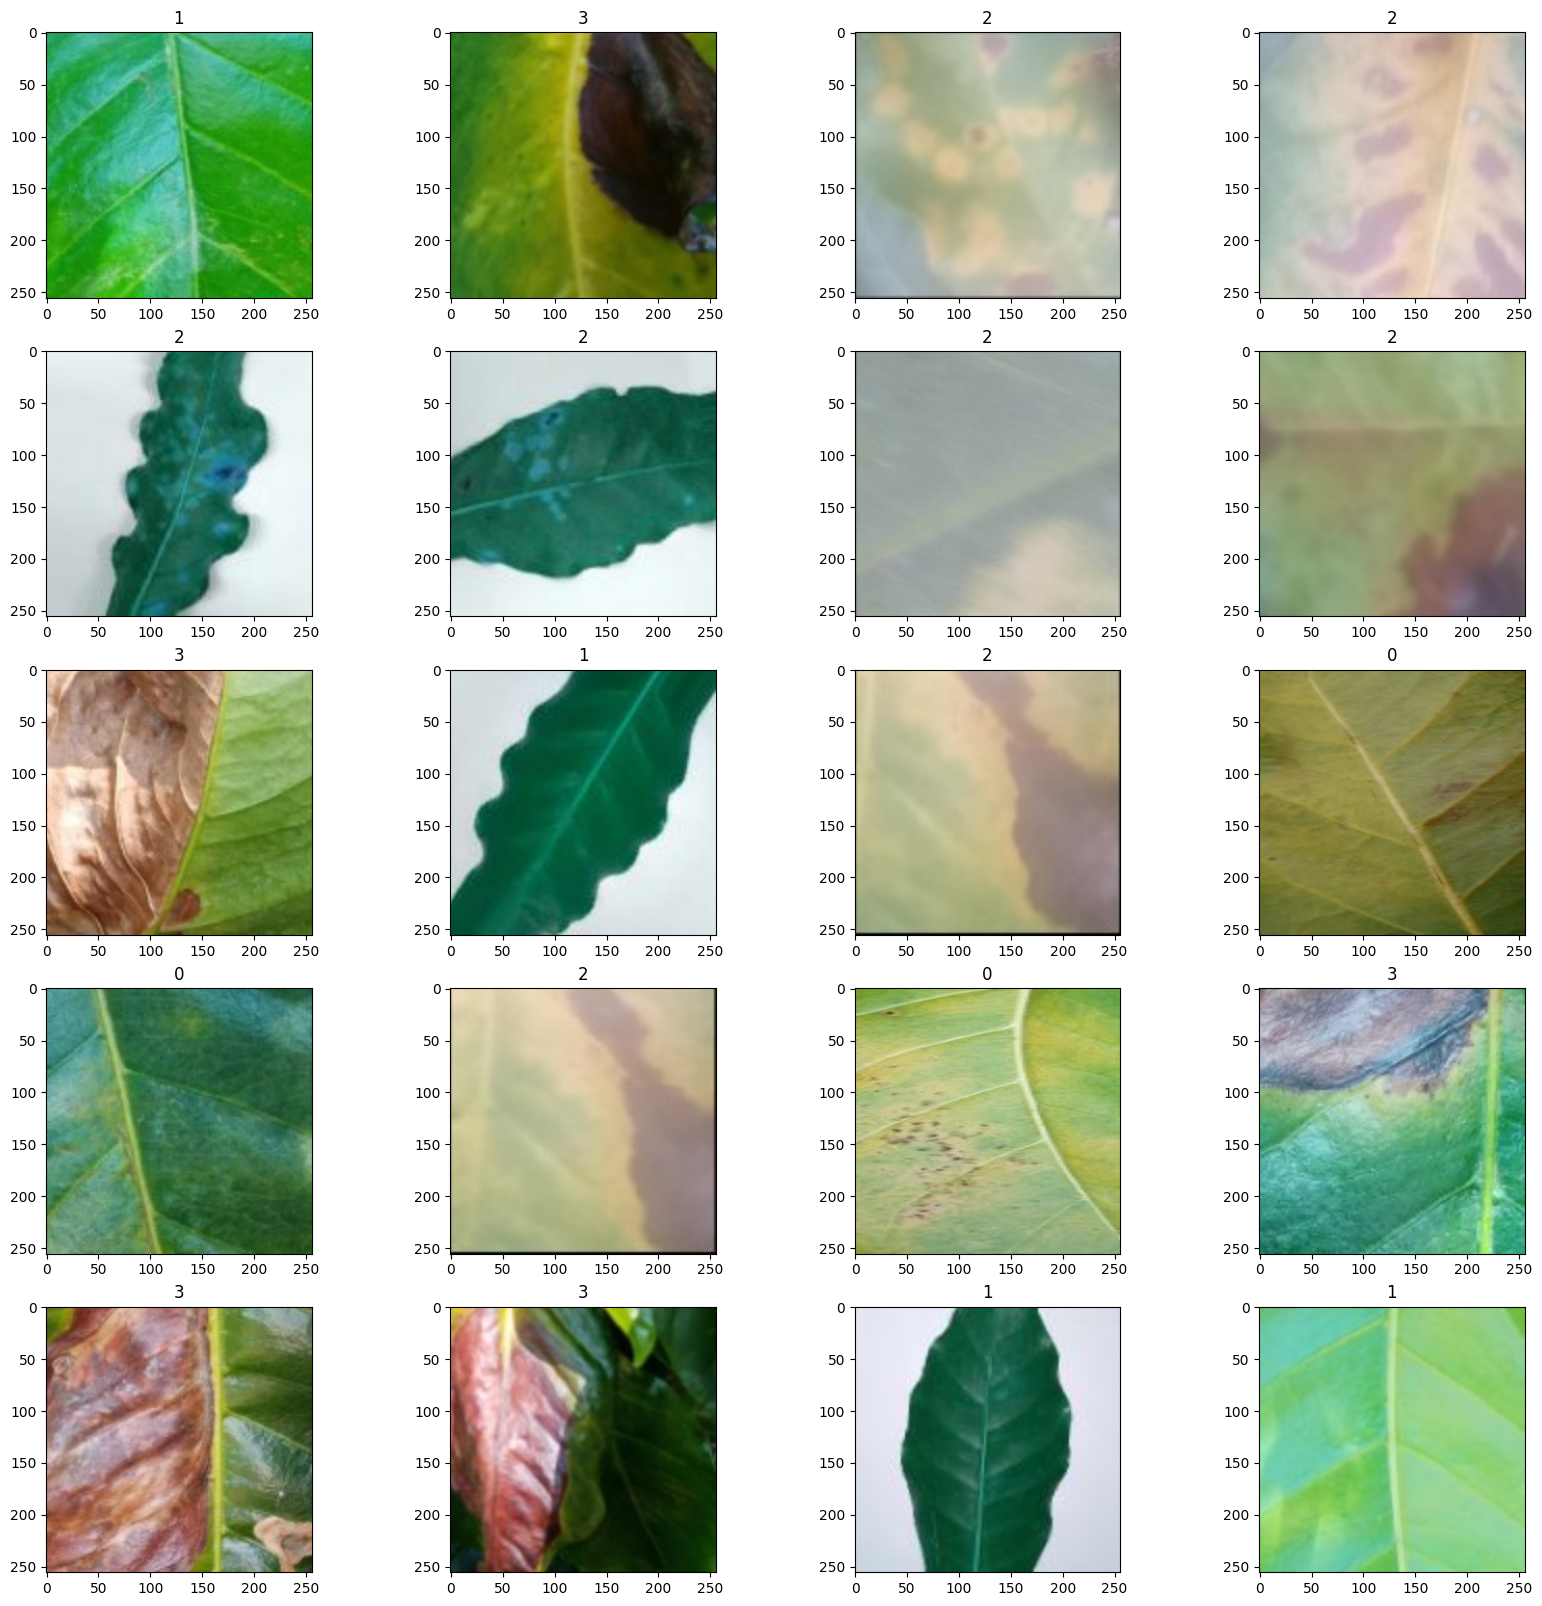

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
for i in range(5):
    for j in range(4):
        idx = i * 4 + j
        ax[i, j].imshow(batch_scaled[0][idx])
        ax[i, j].set_title(batch_scaled[1][idx])

plt.show()

From the above, we can see the images with their assigned classes.

We visualize the distribution of each class in the training and test sets.

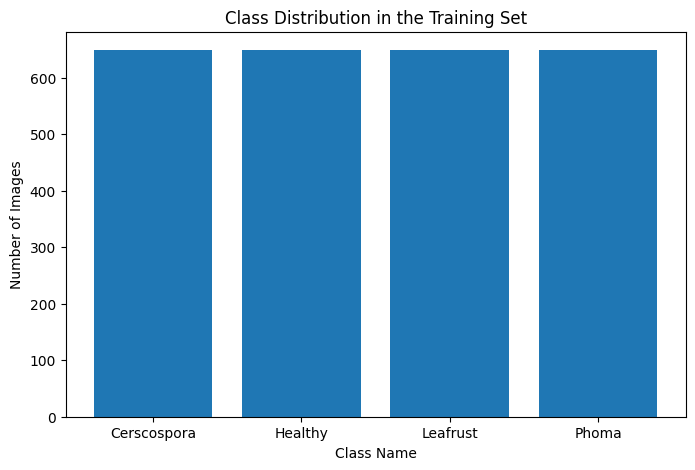

In [12]:
# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution = train.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the training set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution)
plt.title("Class Distribution in the Training Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()

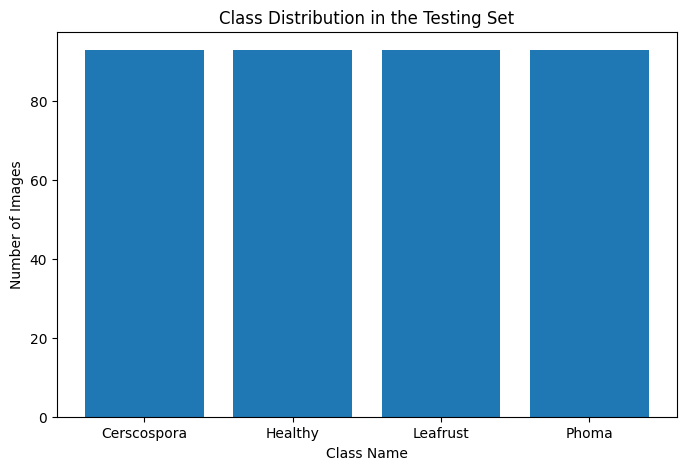

In [13]:
# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution_test = test.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the testing set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution_test)
plt.title("Class Distribution in the Testing Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()

We load the images from the directory and plot five images from each class.

In [14]:
main_folder_path = "/content/drive/MyDrive/Imageclassification3/Data"
images = []

for image_class in os.listdir(main_folder_path):
    for image in os.listdir(os.path.join(main_folder_path, image_class)):
        image_path = os.path.join(main_folder_path, image_class, image)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Image {image_path} could not be loaded.")
            continue
        images.append(img)

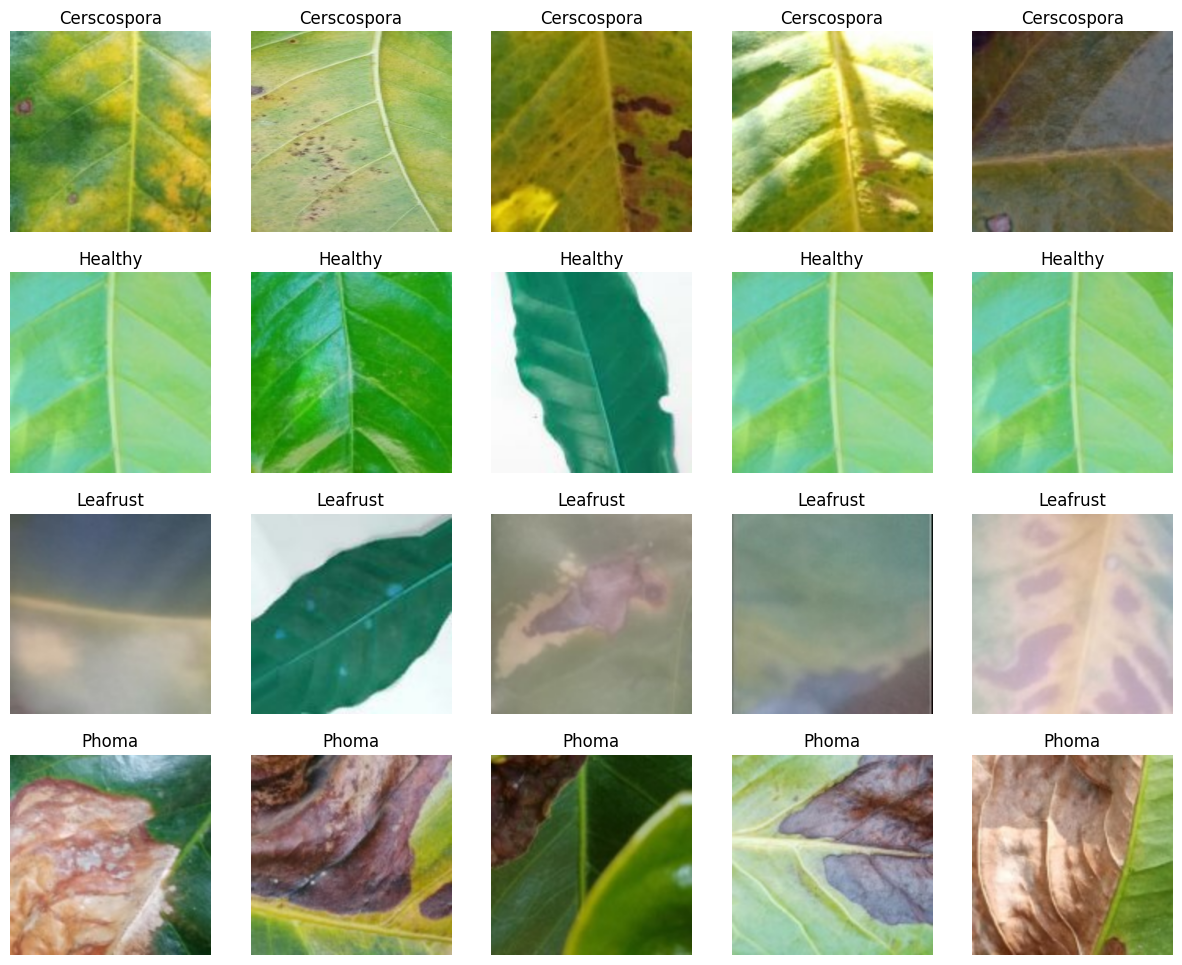

In [15]:
images_by_class = {class_name: [] for class_name in class_names}

# Iterate through the dataset to collect five images for each class
for images, labels in data:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if len(images_by_class[class_name]) < 5:
            images_by_class[class_name].append(image.numpy())

# Plot the selected images
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 3 * len(class_names)))
for i, class_name in enumerate(class_names):
    for j, image in enumerate(images_by_class[class_name]):
        axes[i, j].imshow(image.astype(int))
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

plt.show()

The above plot shows five images from each class.

In [16]:
image_statistics_by_class = {class_name: {'mean': [], 'std': []} for class_name in class_names}

# Iterate through the dataset to calculate image statistics for each class
for images, labels in data:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        image_np = image.numpy()
        mean_values = np.mean(image_np, axis=(0, 1))
        std_values = np.std(image_np, axis=(0, 1))

        # Store statistics in the dictionary
        image_statistics_by_class[class_name]['mean'].append(mean_values)
        image_statistics_by_class[class_name]['std'].append(std_values)

# Display image statistics
for class_name, statistics in image_statistics_by_class.items():
    mean_values = np.mean(statistics['mean'], axis=0)
    std_values = np.mean(statistics['std'], axis=0)
    print(f"{class_name} - Mean values: {mean_values}, Std values: {std_values}")


Cerscospora - Mean values: [121.76627 136.07367  76.1142 ], Std values: [34.370064 29.52207  34.861458]
Healthy - Mean values: [101.7592  177.86247 113.43119], Std values: [44.20804  27.321201 46.579483]
Leafrust - Mean values: [146.73724 160.34663 143.0774 ], Std values: [43.12189  30.854395 32.087067]
Phoma - Mean values: [137.64172 145.31422 103.19717], Std values: [46.71672  39.924957 44.30027 ]


The above shows image statistics:
- Leafrust - Mean values: [146.73724 160.34663 143.0774 ]
- Cerscospora - Mean values: [121.76627 136.07367  76.1142 ]
- Phoma - Mean values: [137.64172 145.31422 103.19717]
- Healthy - Mean values:  [101.7592  177.86247 113.43119]

The values represent the pixel intesity for each color channel (Red, Green,Blue) in the coffee rust images:

- Cerscospora - Std values: [34.370064 29.52207  34.861458]
- Healthy - Std values: [44.20804  27.321201 46.579483]
- Leafrust - Std values: [43.12189  30.854395 32.087067]
- Phoma - Std values: [46.71672  39.924957 44.30027 ]

These values represent the standard deviation of pixel intensities for each color channel. A higher standard deviation implies greater variability in pixel intensities.

From the above, higher mean values suggest brigher images in the corresponding color channel. e.g Coffee Rust images tend to have higher average intensities in the red channel compared to Cerscospora, Phoma and healthy leaf images.

Healthy leaf images tend to have higher average intensities in the green channel compared to Cerscospora, Phoma and leafrust leaf images.

# **Modeling**

In [17]:
# Create a baseline model
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Fit the model
baseline_model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
649/649 [==============================] - 62s 92ms/step - loss: 7.8297 - accuracy: 0.6855 - val_loss: 0.8206 - val_accuracy: 0.8721
Epoch 2/5
649/649 [==============================] - 60s 92ms/step - loss: 1.2658 - accuracy: 0.8214 - val_loss: 0.5100 - val_accuracy: 0.8884
Epoch 3/5
649/649 [==============================] - 60s 93ms/step - loss: 0.4478 - accuracy: 0.8623 - val_loss: 0.1973 - val_accuracy: 0.8980
Epoch 4/5
649/649 [==============================] - 61s 93ms/step - loss: 0.4896 - accuracy: 0.8169 - val_loss: 0.3248 - val_accuracy: 0.8876
Epoch 5/5
649/649 [==============================] - 61s 93ms/step - loss: 0.3205 - accuracy: 0.8790 - val_loss: 0.2639 - val_accuracy: 0.8943


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = baseline_model.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 37s 39ms/step - loss: 0.2530 - accuracy: 0.8964
Test Accuracy: 0.8963765501976013


In [19]:
# Create a deeper model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model on the dataset
history_2 = model_2.fit(train, epochs=5, validation_data=val)


Epoch 1/5
649/649 [==============================] - 64s 92ms/step - loss: 0.2557 - accuracy: 0.9179 - val_loss: 0.1374 - val_accuracy: 0.9405
Epoch 2/5
649/649 [==============================] - 60s 93ms/step - loss: 0.0986 - accuracy: 0.9625 - val_loss: 0.5087 - val_accuracy: 0.8414
Epoch 3/5
649/649 [==============================] - 60s 93ms/step - loss: 0.0835 - accuracy: 0.9687 - val_loss: 0.0858 - val_accuracy: 0.9669
Epoch 4/5
649/649 [==============================] - 61s 94ms/step - loss: 0.0446 - accuracy: 0.9845 - val_loss: 0.0439 - val_accuracy: 0.9872
Epoch 5/5
649/649 [==============================] - 60s 93ms/step - loss: 0.0672 - accuracy: 0.9817 - val_loss: 0.0573 - val_accuracy: 0.9829


In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 37s 39ms/step - loss: 0.0536 - accuracy: 0.9844
Test Accuracy: 0.9844226241111755


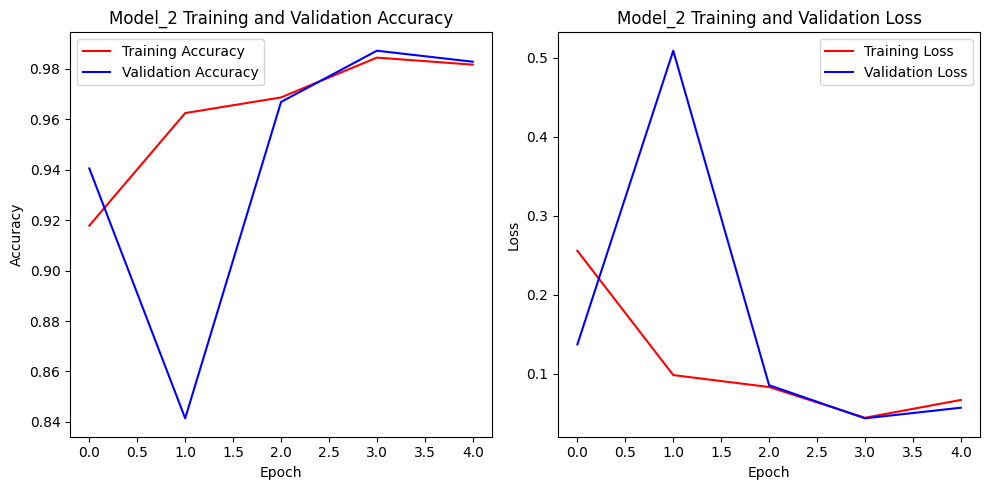

In [21]:
# Access training history
training_accuracy = history_2.history['accuracy']
training_loss = history_2.history['loss']
validation_accuracy = history_2.history['val_accuracy']
validation_loss = history_2.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.epoch, training_accuracy, 'r', label='Training Accuracy')
plt.plot(history_2.epoch, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Model_2 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.epoch, training_loss, 'r', label='Training Loss')
plt.plot(history_2.epoch, validation_loss, 'b', label='Validation Loss')
plt.title('Model_2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Define the CNN model
model_3 = models.Sequential()

# Convolutional layers
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model_3.add(layers.Flatten())

# Dense layers
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(4, activation='softmax'))

# Compile the model
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model_3.summary()

# Train the model on the dataset
history_3 = model_3.fit(train, epochs=5, validation_data=val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 128)      

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_3.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 37s 38ms/step - loss: 0.0480 - accuracy: 0.9858
Test Accuracy: 0.9857771992683411


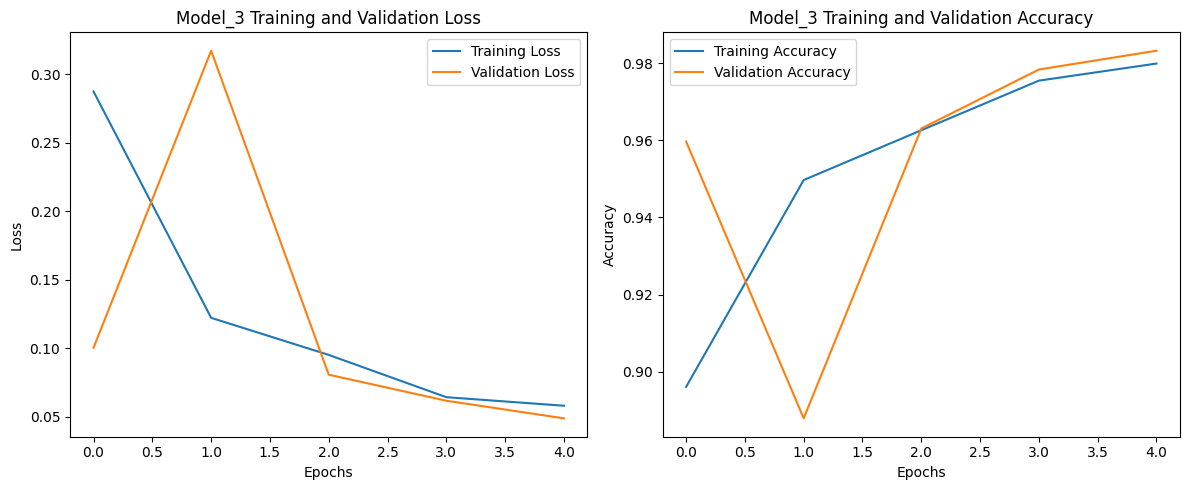

In [24]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model_3 Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model_3 Training and Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [25]:

model_4 = models.Sequential()

# Convolutional layers
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))  # Additional convolutional layer
model_4.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model_4.add(layers.Flatten())

# Dense layers
model_4.add(layers.Dense(256, activation='relu'))  # Increased number of units
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(4, activation='softmax'))

# Compile the model
model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model_4.summary()

# Train the model on the dataset
history_4 = model_4.fit(train, epochs=5, validation_data=val)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 128)      

In [26]:
test_loss, test_accuracy = model_4.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 38s 39ms/step - loss: 0.0234 - accuracy: 0.9909
Test Accuracy: 0.9908567667007446


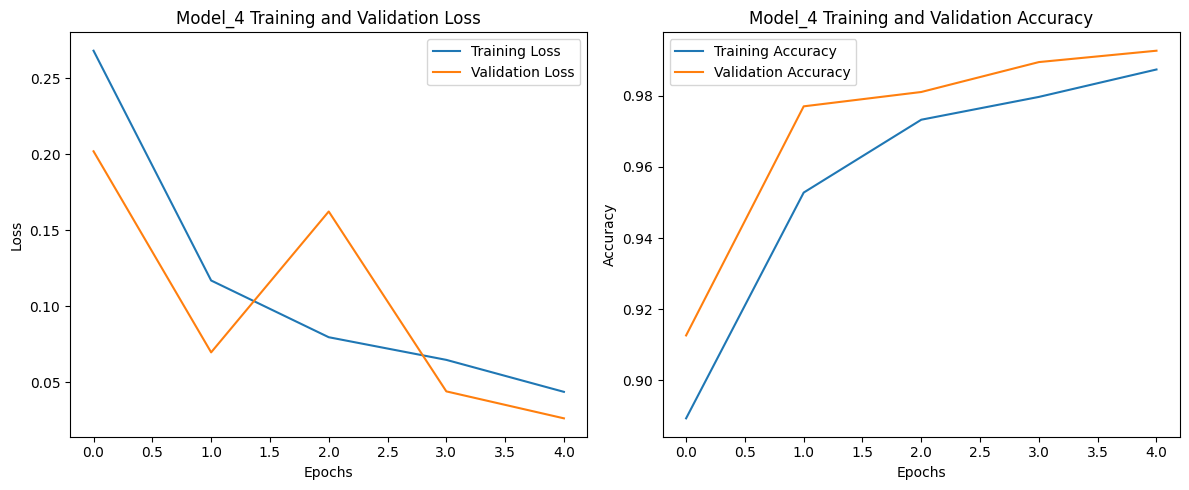

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model_4 Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model_4 Training and Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [28]:
# Save the trained models
baseline_model.save('/content/drive/MyDrive/Imageclassification3/Final_Models/baseline_model.h5')
model_2.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_2.h5')
model_3.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_3.h5')
model_4.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Load the saved model
saved_model_path = '/content/drive/MyDrive/Imageclassification3/Final_Models/model_2.h5'
model = load_model(saved_model_path)

# Preprocess the image
image_path = '/content/download (2).jpg'
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(preprocessed_image)
class_names = data.class_names

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Display the prediction
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 0s 70ms/step
Predicted Class: Leafrust


#**Conclusion**#
Model Performance: Each model iteration showed significant improvement in accuracy, indicating the effectiveness of incorporating more sophisticated architectures.

Feature Extraction: Convolutional layers proved crucial in capturing hierarchical and intricate features within leaf images, resulting in higher classification accuracy.

Optimization Techniques: Utilizing the Adam optimizer contributed to model convergence and enhanced performance across different architectures.

#**Recommendations**#

**Early Disease Detection:**  

The CNN model is designed for early detection of coffee leaf diseases,that is Coffee Rust, Cercospora, and Phoma.
Early detection allows farmers to intervene promptly, minimizing the impact of diseases on the coffee crop.

**Diverse Image Sources:**

Collecting photos from different locations with varied lighting,resolutions and cameras as well as crowdsourced images will improve model robustness and ensure its viability in the long term

**Computational Resources**

Limited computational resources impacted the complexity of the model. Leveraging dedicated cloud computing services would enable the exploration of more complex architectures and deeper experimentation in order to achieve an optimal model


**Hyperparameter Tuning:**

To maximize the performance of the model hyperparameter tuning on variables such as learning rate,batch size and regularization strategies.

**Ensemble Learning:**

Experiment with ensemble techniques like bagging and stacking to increase the robustness of the model.

**Transfer Learning:**

Fine tuning a pretrained model such as ResNet may yield a further increase in performance. By utilizing pre trained models we can greatly increase the models efficiency and accuracy

**Model Interpretability:**

Utilizing tools such as Grad-CAM and SHAP can provide a deeper understanding on which sections of the images contribute most significantly to the model's prediction enhancing transparency in the models behaviour.












#**Next Steps**#  

**Continuous Monitoring and Retraining:**

Establish a system to track model performance in real-world settings continuously. Retrain the model on a regular basis to adapt to changing conditions and evolving disease pattern in real time. model performance in real-world settings continuously.

**Education and Awareness Campaigns:**

Start education and awareness programs to provide coffee farmers with information on disease prevention, early detection, and sustainable farming practices,


**Long-Term Sustainability Planning:**

Create long-term sustainability plans for the project that address resource allocation, community involvement, and scalability.

**User Feedback and Iteration:**

Source feedback from farmers on the deployed model and use that to iterate and improve the model over time

**Testing Phase:**

Test the model in real world settings with the aid of local farmers and a plant pathologist.






